In [1]:
import os
import fnmatch

import cv2
import pydicom

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm

from sklearn.model_selection import train_test_split

# Load Datasets

In [2]:
ANNOTATIONS_DIR = '../Datasets/CBIS-DDSM/'
IMAGES_DIR = '../Datasets/CBIS-DDSM/CBIS-DDSM/'

# Target path for the Cleaned CBIS-DDSM dataset after preprocessing
TARGET_DIR = '../Datasets/CCBIS-DDSM/'

In [3]:
# CBIS-DDSM already comes with a training and testing split

# Load Training Data
train_calc_df = pd.read_csv(os.path.join(ANNOTATIONS_DIR, 'calc_case_description_train_set.csv'))
train_mass_df = pd.read_csv(os.path.join(ANNOTATIONS_DIR, 'mass_case_description_train_set.csv'))
train_mass_df = train_mass_df.rename(columns={'breast_density':'breast density'})

# Load Testing Data
test_calc_df = pd.read_csv(os.path.join(ANNOTATIONS_DIR, 'calc_case_description_test_set.csv'))
test_mass_df = pd.read_csv(os.path.join(ANNOTATIONS_DIR, 'mass_case_description_test_set.csv'))
test_mass_df = test_mass_df.rename(columns={'breast_density':'breast density'})

We will also `concat` the datasets, to create a calcificacion and masses joint dataset, as we are interested in training a model that can find both type of abnormalities

In [4]:
train_df = pd.concat([train_calc_df, train_mass_df], axis=0, ignore_index=True)
test_df = pd.concat([test_calc_df, test_mass_df], axis=0, ignore_index=True)
train_df

,patient_id,breast density,left or right breast,image view,abnormality id,abnormality type,calc type,calc distribution,assessment,pathology,subtlety,image file path,cropped image file path,ROI mask file path,mass shape,mass margins
0,P_00005,3,RIGHT,CC,1,calcification,AMORPHOUS,CLUSTERED,3,MALIGNANT,3,Calc-Training_P_00005_RIGHT_CC/1.3.6.1.4.1.959...,Calc-Training_P_00005_RIGHT_CC_1/1.3.6.1.4.1.9...,Calc-Training_P_00005_RIGHT_CC_1/1.3.6.1.4.1.9...,NaN,NaN
1,P_00005,3,RIGHT,MLO,1,calcification,AMORPHOUS,CLUSTERED,3,MALIGNANT,3,Calc-Training_P_00005_RIGHT_MLO/1.3.6.1.4.1.95...,Calc-Training_P_00005_RIGHT_MLO_1/1.3.6.1.4.1....,Calc-Training_P_00005_RIGHT_MLO_1/1.3.6.1.4.1....,NaN,NaN
2,P_00007,4,LEFT,CC,1,calcification,PLEOMORPHIC,LINEAR,4,BENIGN,4,Calc-Training_P_00007_LEFT_CC/1.3.6.1.4.1.9590...,Calc-Training_P_00007_LEFT_CC_1/1.3.6.1.4.1.95...,Calc-Training_P_00007_LEFT_CC_1/1.3.6.1.4.1.95...,NaN,NaN
3,P_00007,4,LEFT,MLO,1,calcification,PLEOMORPHIC,LINEAR,4,BENIGN,4,Calc-Training_P_00007_LEFT_MLO/1.3.6.1.4.1.959...,Calc-Training_P_00007_LEFT_MLO_1/1.3.6.1.4.1.9...,Calc-Training_P_00007_LEFT_MLO_1/1.3.6.1.4.1.9...,NaN,NaN
4,P_00008,1,LEFT,CC,1,calcification,NaN,REGIONAL,2,BENIGN_WITHOUT_CALLBACK,3,Calc-Training_P_00008_LEFT_CC/1.3.6.1.4.1.9590...,Calc-Training_P_00008_LEFT_CC_1/1.3.6.1.4.1.95...,Calc-Training_P_00008_LEFT_CC_1/1.3.6.1.4.1.95...,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2859,P_02033,2,RIGHT,MLO,1,mass,NaN,NaN,3,MALIGNANT,4,Mass-Training_P_02033_RIGHT_MLO/1.3.6.1.4.1.95...,Mass-Training_P_02033_RIGHT_MLO_1/1.3.6.1.4.1....,Mass-Training_P_02033_RIGHT_MLO_1/1.3.6.1.4.1....,IRREGULAR,ILL_DEFINED
2860,P_02079,2,RIGHT,CC,1,mass,NaN,NaN,3,MALIGNANT,5,Mass-Training_P_02079_RIGHT_CC/1.3.6.1.4.1.959...,Mass-Training_P_02079_RIGHT_CC_1/1.3.6.1.4.1.9...,Mass-Training_P_02079_RIGHT_CC_1/1.3.6.1.4.1.9...,ROUND,SPICULATED
2861,P_02079,2,RIGHT,MLO,1,mass,NaN,NaN,3,MALIGNANT,5,Mass-Training_P_02079_RIGHT_MLO/1.3.6.1.4.1.95...,Mass-Training_P_02079_RIGHT_MLO_1/1.3.6.1.4.1....,Mass-Training_P_02079_RIGHT_MLO_1/1.3.6.1.4.1....,ROUND,SPICULATED
2862,P_02092,2,LEFT,CC,1,mass,NaN,NaN,3,MALIGNANT,2,Mass-Training_P_02092_LEFT_CC/1.3.6.1.4.1.9590...,Mass-Training_P_02092_LEFT_CC_1/1.3.6.1.4.1.95...,Mass-Training_P_02092_LEFT_CC_1/1.3.6.1.4.1.95...,IRREGULAR,SPICULATED


In [5]:
# Images and mask paths are different from what is specified in the dataset.
# We will fix this using our own 'Image' and 'Mask' columns
train_df['Image'] = train_df['image file path'].str.split('/').str[0]
train_df['Mask'] = train_df['ROI mask file path'].str.split('/').str[0]

test_df['Image'] = test_df['image file path'].str.split('/').str[0]
test_df['Mask'] = test_df['ROI mask file path'].str.split('/').str[0]

In [6]:
# Remove columns that will not be used
train_df = train_df.drop(['image file path', 'cropped image file path', 'ROI mask file path', 'calc type', 'calc distribution', 'mass shape', 'mass margins'], axis=1)
test_df = test_df.drop(['image file path', 'cropped image file path', 'ROI mask file path', 'calc type', 'calc distribution', 'mass shape', 'mass margins'], axis=1)

In [7]:
# Standarize column names
columns = {
    'patient_id': 'Patient_ID',
    'breast_density':'Breast_Density',
    'left or right breast':'Left_Right_Breast',
    'image view':'Image_View',
    'abnormality id':'Abnormality_ID',
    'abnormality type':'Abnormality_Type',
    'assessment':'Assessment',
    'pathology':'Pathology',
    'subtlety':'Subtlety'
}

train_df = train_df.rename(columns=columns)
test_df = test_df.rename(columns=columns)

In [8]:
print(train_df.shape)
print(test_df.shape)
train_df

(2864, 11)
(704, 11)


,Patient_ID,breast density,Left_Right_Breast,Image_View,Abnormality_ID,Abnormality_Type,Assessment,Pathology,Subtlety,Image,Mask
0,P_00005,3,RIGHT,CC,1,calcification,3,MALIGNANT,3,Calc-Training_P_00005_RIGHT_CC,Calc-Training_P_00005_RIGHT_CC_1
1,P_00005,3,RIGHT,MLO,1,calcification,3,MALIGNANT,3,Calc-Training_P_00005_RIGHT_MLO,Calc-Training_P_00005_RIGHT_MLO_1
2,P_00007,4,LEFT,CC,1,calcification,4,BENIGN,4,Calc-Training_P_00007_LEFT_CC,Calc-Training_P_00007_LEFT_CC_1
3,P_00007,4,LEFT,MLO,1,calcification,4,BENIGN,4,Calc-Training_P_00007_LEFT_MLO,Calc-Training_P_00007_LEFT_MLO_1
4,P_00008,1,LEFT,CC,1,calcification,2,BENIGN_WITHOUT_CALLBACK,3,Calc-Training_P_00008_LEFT_CC,Calc-Training_P_00008_LEFT_CC_1
...,...,...,...,...,...,...,...,...,...,...,...
2859,P_02033,2,RIGHT,MLO,1,mass,3,MALIGNANT,4,Mass-Training_P_02033_RIGHT_MLO,Mass-Training_P_02033_RIGHT_MLO_1
2860,P_02079,2,RIGHT,CC,1,mass,3,MALIGNANT,5,Mass-Training_P_02079_RIGHT_CC,Mass-Training_P_02079_RIGHT_CC_1
2861,P_02079,2,RIGHT,MLO,1,mass,3,MALIGNANT,5,Mass-Training_P_02079_RIGHT_MLO,Mass-Training_P_02079_RIGHT_MLO_1
2862,P_02092,2,LEFT,CC,1,mass,3,MALIGNANT,2,Mass-Training_P_02092_LEFT_CC,Mass-Training_P_02092_LEFT_CC_1


For our purposes, the class `BENIGN_WITHOUT_CALLBACK` is the same as `BENIGN`. 

In [9]:
train_df['Pathology'] = train_df['Pathology'].str.replace('BENIGN_WITHOUT_CALLBACK', 'BENIGN', regex=False)
test_df['Pathology'] = test_df['Pathology'].str.replace('BENIGN_WITHOUT_CALLBACK', 'BENIGN', regex=False)

# Exploratory Analysis

In [10]:
def display_column_countplot(data_list, column_names, title_list):
    fig, ax = plt.subplots(len(column_names), len(data_list), figsize=(5*len(data_list), 4*len(column_names)))
    for i, column_name in enumerate(column_names):
        for j, data in enumerate(data_list):
            sns.countplot(x=column_name, 
                          data=data, 
                          ax=ax[i,j], 
                          order=sorted(data[column_name].unique())
            ).set_title(title_list[j])
            
    plt.tight_layout()
    plt.show()

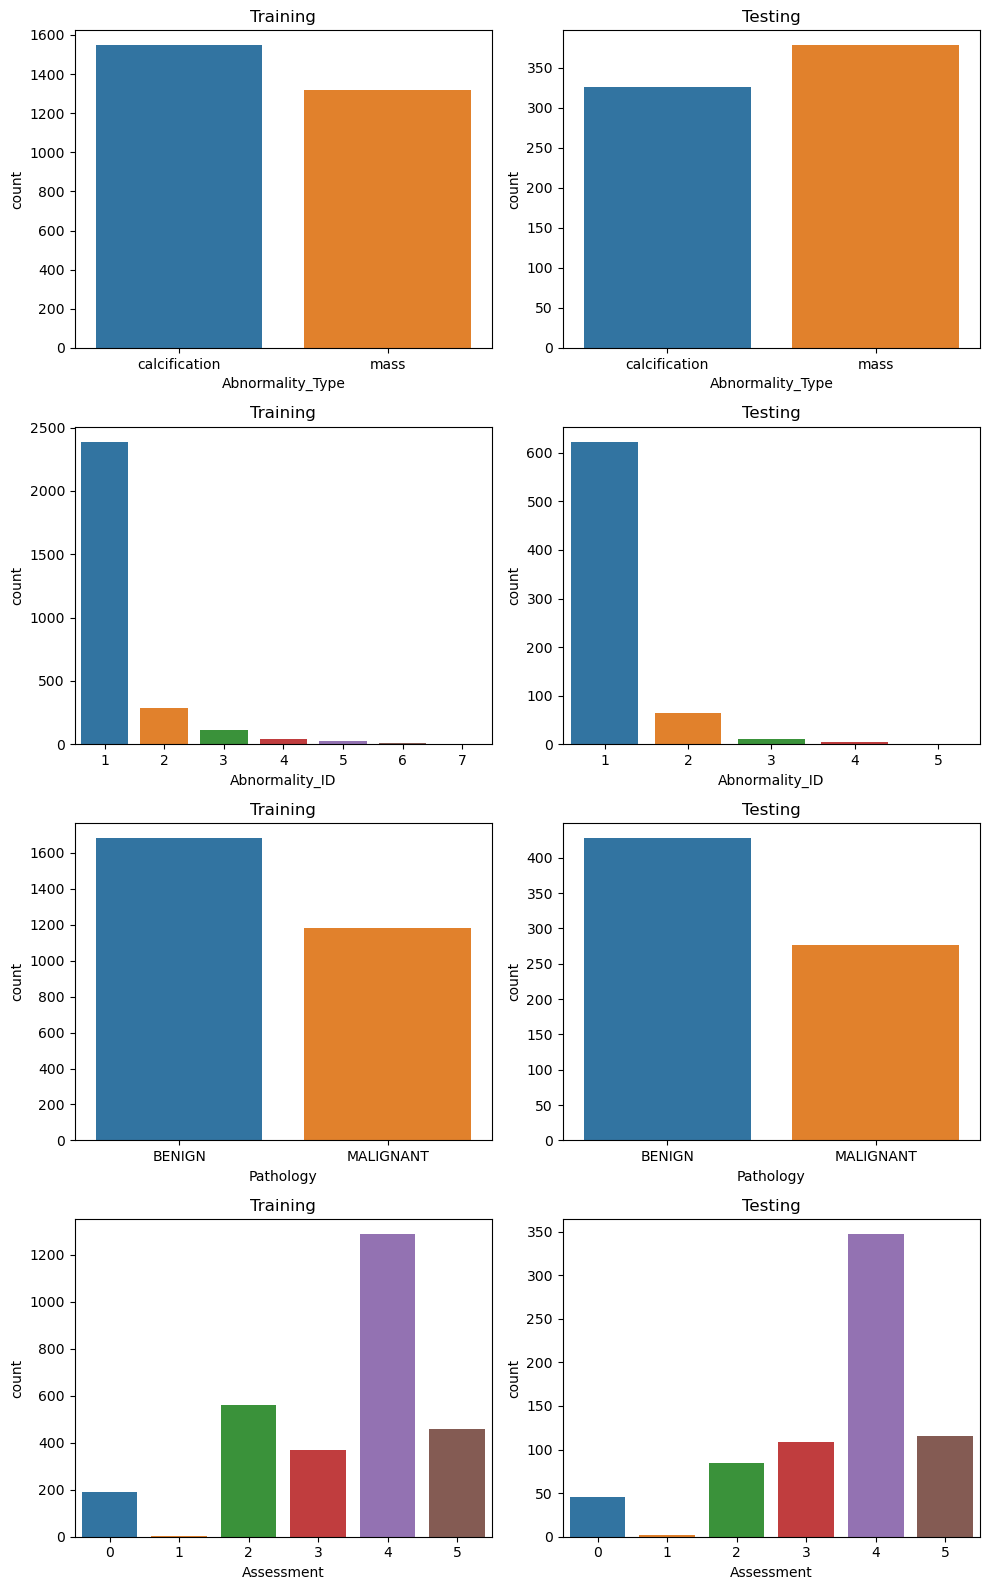

In [11]:
display_column_countplot([train_df, test_df], ['Abnormality_Type', 'Abnormality_ID', 'Pathology', 'Assessment'], ['Training', 'Testing'])

# Remove Faulty Images

Some of the mask images have different size than the corresponding mammography. In these cases, since we are not medical experts, we decided to just remove these masks from the dataset.

In [12]:
def file_exists(file):
    return os.path.isfile(file)

def find_dcm_files(folder):
    '''
    Function to find .dcm files inside a folder. Works with nested folders as well.
    
    Parameters
    ----------
    folder: string
        The path of the folder to look in.
        
    Returns
    -------
    list
        A list containing the full path of all .dcm files found inside the folder.
    '''
    dcm_files = []
    for path, dirs, files in os.walk(folder):
        for file in files:
            if fnmatch.fnmatch(file, '*.dcm'):
                fullname = os.path.join(path, file)
                dcm_files.append(fullname)
    return dcm_files

# We use this helper function to correctly find the mask from the crop when searching the CBIS-DDSM folders
# The mask will always be the biggest file of the two
def find_biggest_file(file_list):
    '''
    Find the biggest file (in bytes) from a list of paths. 
    
    Parameters
    ----------
    file_list: list
        A list with paths to the files we want to analyze
        
    Returns
    -------
    string
        The string corresponding to the path with the biggest size in bytes
    '''
    biggest_file = max(file_list, key=lambda x: os.stat(x).st_size)
    return biggest_file

In [13]:
def dcm_to_array(file, normalize=False):
    '''
    Transforms a .dcm file to a standard image numpy array (values between [0, 255])
    
    Parameters
    ----------
    file: string
        The path of the file containing the .dcm image
    normalize: bool, optional
        Indicates wether normalization of the values is required to be in range [0, 255].
        If set to True, all pixel values will be divided by 256. Default is False
        
    Returns
    -------
    np.array
        A numpy array containing the pixel values of the dcm file
    '''
    ds = pydicom.dcmread(file)
    
    # Rescale the pixel values of the DICOM image, so that they are in the [0, 255] range
    if normalize:
        image = (ds.pixel_array / 256).astype(np.uint8)
    else:
        image = (ds.pixel_array).astype(np.uint8)
    
    return image

In [14]:
def remove_faulty(df):
    '''
    Removes faulty mask images. These occur when the mask shape doesn't match the mammography shape.
    The faulty mask image path is removed from the dataset, and added to a removed.log file.
    If the log file already exists, it just deletes the specified files, without checking again
    Parameters
    ----------
    df: Pandas DataFrame
        The DataFrame containing the image and masks paths
    
    Returns
    -------
    Pandas DataFrame
        The DataFrame with the faulty masks removed
    '''
    if not file_exists('CBIS-DDSM_removed.log'):
        for image in tqdm(df['Image'].unique()):
            image_df = df[df['Image'] == image]

            # Get DICOM image and transform to numpy array with values in range [0, 255]
            mammography_path = find_biggest_file(find_dcm_files(IMAGES_DIR + image))
            mammography = dcm_to_array(mammography_path, normalize=True)        

            for i, row in image_df.iterrows():
                mask_file = find_biggest_file(find_dcm_files(IMAGES_DIR + row['Mask']))
                mask = dcm_to_array(mask_file)

                if not (mammography.shape == mask.shape):
                    log = open('CBIS-DDSM_removed.log', 'a')
                    log.write(row['Mask'] + '\n')
                    log.close()
        
    log = open('CBIS-DDSM_removed.log', 'r')
    lines = log.readlines()
    lines = [line.strip() for line in lines]

    temp_df = df[df['Mask'].isin(lines)]
    df = pd.concat([df, temp_df, temp_df]).drop_duplicates(keep=False)
    return df

In [15]:
train_df = remove_faulty(train_df)
test_df = remove_faulty(test_df)

# Split the Data

As indicated earlier, CBIS-DDSM comes with an already split training and testing set. We will create a validation set from the training data.

In [16]:
train_df, validation_df = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df['Pathology'])

# Create the Dataset

In this process, we will create the dataset that will be used by the neural network. In order to do this, we need to do:
- Find the image in the indicated folder: Names that come in the provided `.csv` don't match the folder names of the files.
- Transform DICOM images into a simpler format, like png o jpg.
- The provided masks files only display a single lession, and if there is more than one lession it is provided as two different masks paths. We join all masks into a single mask file.

In [17]:
# Sort the DataFrames to avoid problems when getting the bounding boxes per mask
train_df = train_df.sort_values(by=['Image', 'Mask'])
validation_df = validation_df.sort_values(by=['Image', 'Mask'])
test_df = test_df.sort_values(by=['Image', 'Mask'])

In [18]:
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [19]:
def create_CCBIS_DDSM_dataset(df, split):
    '''
    Creates the CCBIS-DDSM (Curated CBIS-DDSM) dataset.
    This process includes:
    - Transforming images from DICOM format to .png
    - Finding the bounding box coordinates for all lessions
    - Unifying all masks into a single mask file
    It then saves the preprocessed images into the TARGET_DIR, into the corresponding images/ and masks/ folders.
    
    Parameters
    ----------
    df: Pandas DataFrame
        The Pandas DataFrame that contains all necessary information about the images, paths and lessions.
    split: string
        Wether the passed DataFrame and generated images are from the Training, Validation or Testing split.
        
    Returns
    -------
    np.array
        A numpy array containing all the bounding boxes for the specified DataFrame
    '''    
    bboxes = []
    for image in tqdm(df['Image'].unique()):
        image_df = df[df['Image'] == image]

        # Get DICOM image and transform to numpy array with values in range [0, 255]
        mammography_path = find_biggest_file(find_dcm_files(IMAGES_DIR + image))
        mammography = dcm_to_array(mammography_path, normalize=True)        
        
        # Create the mask that includes all masks for the mammography
        final_mask = np.zeros(mammography.shape, dtype=np.uint8)
        for i, row in image_df.iterrows():
            # Load the mask file
            mask_file = find_biggest_file(find_dcm_files(IMAGES_DIR + row['Mask']))
            mask = dcm_to_array(mask_file)
            
            # Clean up the mask with erosion and dilation, to remove noise
            kernel = np.ones((5, 5), np.uint8)
            mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

            # Find contours for the mask image
            contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            # Find bounding box for the contour
            # Each bounding box will be an array in (x1, y1, w, h) format
            # Since noise can create some contours as well, we will only use the biggest contour for the mask
            cnt = max(contours, key=cv2.contourArea)
            x, y, w, h = cv2.boundingRect(cnt)
            bboxes.append([x, y, w, h])
            
            # Join segmentation masks in one array
            final_mask = cv2.bitwise_or(final_mask, mask)

        # Get the save file paths and save the images
        mammography = Image.fromarray(mammography)
        final_mask = Image.fromarray(final_mask)

        image_path = TARGET_DIR + split + 'images/' + image.replace('-Test', '').replace('-Training', '') + '.png'
        mask_path = TARGET_DIR + split + 'masks/' + image.replace('-Test', '').replace('-Training', '') + '.png'

        mammography.save(image_path)
        final_mask.save(mask_path)
        
    bboxes = np.array(bboxes)
    return bboxes

In [20]:
create_dir(TARGET_DIR)
create_dir(TARGET_DIR + 'train/images/')
create_dir(TARGET_DIR + 'train/masks/')
create_dir(TARGET_DIR + 'test/images/')
create_dir(TARGET_DIR + 'test/masks/')
create_dir(TARGET_DIR + 'validation/images/')
create_dir(TARGET_DIR + 'validation/masks/')

In [21]:
train_bboxes = create_CCBIS_DDSM_dataset(train_df, 'train/')
validation_bboxes = create_CCBIS_DDSM_dataset(validation_df, 'validation/')
test_bboxes = create_CCBIS_DDSM_dataset(test_df, 'test/')

100%|████████████████████████████████████████████████████████████████████████████████| 632/632 [23:14<00:00,  2.21s/it]


# Updating the Dataframes

In [22]:
# Add the extracted bounding box information to the DataFrames
dfs = [train_df, validation_df, test_df]
bounding_boxes = [train_bboxes, validation_bboxes, test_bboxes]

# Save the bounding box information to the DataFrame
for i, df in enumerate(dfs):
    df['x1'] = bounding_boxes[i][:, 0]
    df['y1'] = bounding_boxes[i][:, 1]
    df['w'] = bounding_boxes[i][:, 2]
    df['h'] = bounding_boxes[i][:, 3]

In [23]:
# Both are replaced by 'Image', since we now have a single mask instead of numbered masks
train_df['Image'] = 'train/images/' + train_df['Image'].str.replace('-Training', '') + '.png'
train_df['Mask'] = 'train/masks/' + train_df['Image'].str.split('/').str[-1]

validation_df['Image'] = 'validation/images/' + validation_df['Image'].str.replace('-Training', '') + '.png'
validation_df['Mask'] = 'validation/masks/' + validation_df['Image'].str.split('/').str[-1]

test_df['Image'] = 'test/images/' + test_df['Image'].str.replace('-Test', '') + '.png'
test_df['Mask'] = 'test/masks/' + test_df['Image'].str.split('/').str[-1]

In [24]:
# Save the updated DataFrames
train_df.to_csv(TARGET_DIR + 'train.csv', index=False)
validation_df.to_csv(TARGET_DIR + 'validation.csv', index=False)
test_df.to_csv(TARGET_DIR + 'test.csv', index=False)

# Visualizing the Resulting Images

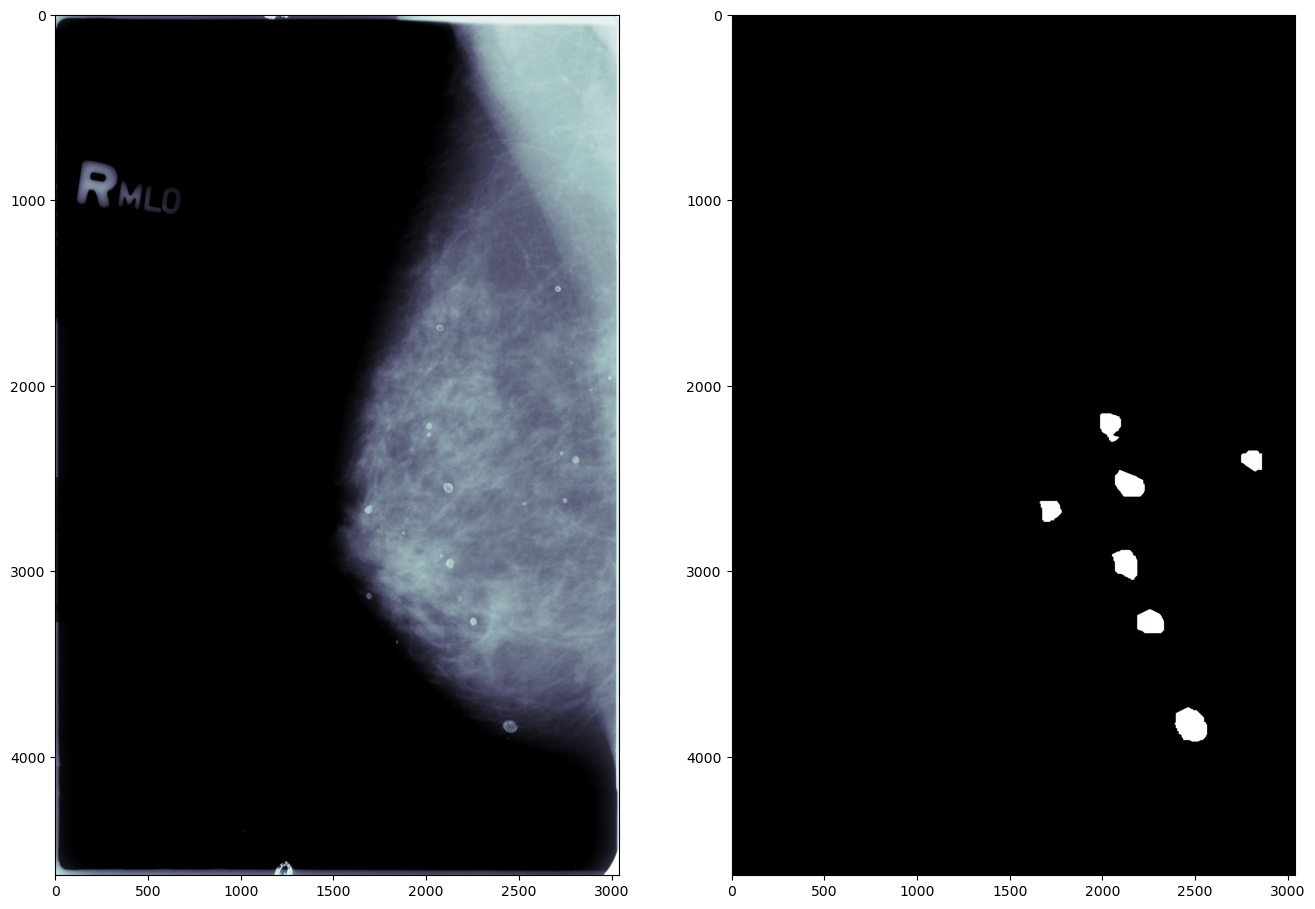

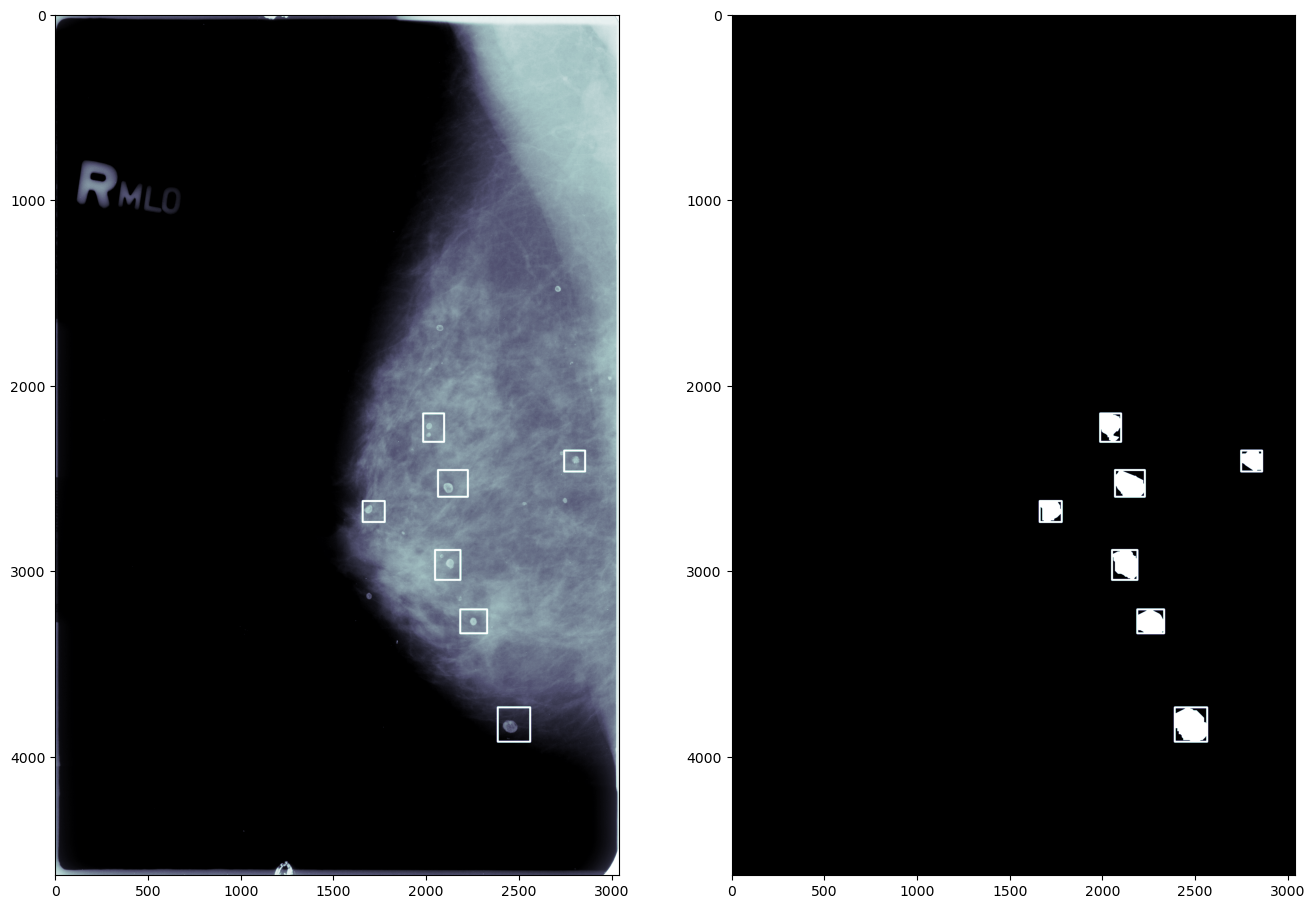

In [25]:
# We choose an image with many abnormalities, to ensure everything is working correctly
IMG_PATH = TARGET_DIR + 'train/images/Calc_P_00112_RIGHT_MLO.png'
MASK_PATH = TARGET_DIR + 'train/masks/Calc_P_00112_RIGHT_MLO.png'

image = np.array(Image.open(IMG_PATH))
mask = np.array(Image.open(MASK_PATH))
fig, ax = plt.subplots(1, 2, figsize=(16, 20))
ax[0].imshow(image, cmap='bone')
ax[1].imshow(mask, cmap='bone')
plt.show()

image_df = train_df[train_df['Image'] == 'train/images/Calc_P_00112_RIGHT_MLO.png']
for i, row in image_df.iterrows():
    x,y,w,h = row['x1'], row['y1'], row['w'], row['h']
    cv2.rectangle(image, (x,y), (x+w, y+h), 255, 10)
    cv2.rectangle(mask, (x,y), (x+w, y+h), 255, 10)

fig, ax = plt.subplots(1, 2, figsize=(16, 20))
ax[0].imshow(image, cmap='bone')
ax[1].imshow(mask, cmap='bone')
plt.show()